# Import Dependencies 

In [1]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils.clip_grad import clip_grad_norm
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import numpy as np
import re
import pandas as pd
import torch

c:\Users\Nemsun\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Processing

In [2]:
df = pd.read_csv('../data/playlist_features_filtered.csv', delimiter=',', index_col=0)

In [4]:
# tokenize the playlist names 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

encoded_playlist_names = tokenizer(text = df.name.to_list(),        
                           add_special_tokens=True,
                           padding = 'max_length',
                           truncation = 'longest_first',
                           max_length = 300,
                           return_attention_mask = True)

input_ids = encoded_playlist_names['input_ids']
attention_masks = encoded_playlist_names['attention_mask']

In [5]:
# put data into numpy arrays
names = np.array(input_ids)
input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)
labels = df[
        ["acousticness","danceability","duration_ms","energy","instrumentalness","key","liveness","loudness","mode","speechiness","tempo","time_signature","valence"]
    ].to_numpy()

print(labels.shape)

(7588, 13)


In [6]:
#formatting the input
test_size = 0.1
seed = 42
train_inputs, test_inputs, train_labels, test_labels = \
            train_test_split(input_ids, labels, test_size=test_size, 
                             random_state=seed)
train_masks, test_masks, _, _ = train_test_split(attention_masks, 
                                        labels, test_size=test_size, 
                                        random_state=seed)

In [7]:
#scale the label scores
score_scaler = StandardScaler()
score_scaler.fit(train_labels)

train_labels = score_scaler.transform(train_labels)
test_labels = score_scaler.transform(test_labels)

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 13

def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader


train_dataloader = create_dataloaders(train_inputs, train_masks, 
                                      train_labels, batch_size)

test_dataloader = create_dataloaders(test_inputs, test_masks, 
                                     test_labels, batch_size)

# Training

In [9]:
# initialize the model
from BertRegressor import BertRegressor
model = BertRegressor(drop_rate = 0.2)

In [10]:
#setting up the training env

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"device: {device.type}")

device: cuda


In [12]:
# set up model parameters

#define the adam optimizer with a 5e-5 learning rate
optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)

#number of epochs
epochs = 5

#total steps
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
loss_fn = nn.MSELoss()

2630


c:\Users\Nemsun\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
#storing the training and validation loss, validation accuracy, and timings
training_stats = []

In [14]:
#evaluation functions
def evaluate(model, loss_function, test_dataloader, device):
    model.eval()
    test_loss, test_r2 = [], []
    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = \
                                 tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        loss = loss_function(outputs, batch_labels)
        test_loss.append(loss.item())
        r2 = r2_score(outputs, batch_labels)
        test_r2.append(r2.item())
    return test_loss, test_r2
    
def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [16]:
#training loop
from tqdm import tqdm

def train(model, optimizer, scheduler, loss_function, epochs,
          train_dataloader, device, clip_value = 2):
    
    for _ in tqdm(range(epochs)):
        model.train()
        
        for batch in tqdm(train_dataloader):
            batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)
            
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            loss = loss_function(outputs.squeeze(), batch_labels.squeeze().float())
            
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
        
        # evaluate the model on the training and test set
        train_loss, train_r2 = evaluate(model, loss_function, train_dataloader, device)
        test_loss, test_r2 = evaluate(model, loss_function, test_dataloader, device)

        training_stats.append(
            {
                'epoch': _ + 1,
                'Training Loss': train_loss,
                'Training R2': train_r2,
                'Test Loss': test_loss,
                'Test R2': test_r2
            }
        )
        
    return model

In [17]:
model = train(model, optimizer, scheduler, loss_fn, epochs, train_dataloader, device, clip_value= 2)

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Nemsun\AppData\Local\Temp\ipykernel_54660\2804211607.py:18: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  clip_grad_norm(model.parameters(), clip_value)
100%|██████████| 5/5 [15:42<00:00, 188.59s/it]


In [45]:
torch.save(model.state_dict(), 'bert_model.pt')

In [46]:
avg_training_data = []

for stat in training_stats:
    avg_training_data.append(
        {
            'epoch': stat['epoch'],
            'Training Loss': np.mean(stat['Training Loss']),
            'Training R2': np.mean(stat['Training R2']),
            'Test Loss': np.mean(stat['Test Loss']),
            'Test R2': np.mean(stat['Test R2'])
        }
    )

In [47]:
import pandas as pd

pd.options.display.precision = 2

pd

df_stats = pd.DataFrame(data=avg_training_data)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Training R2,Test Loss,Test R2
epoch,,,,
1,0.58,0.43,0.56,0.36
2,0.45,0.55,0.54,0.38
3,0.37,0.63,0.50,0.43
4,0.30,0.70,0.50,0.43
5,0.28,0.73,0.50,0.42


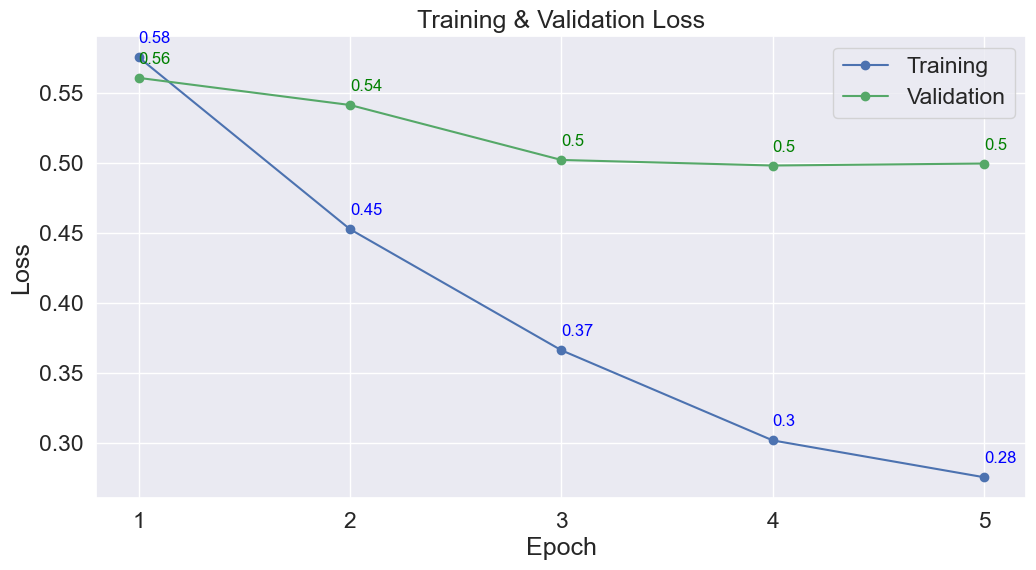

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# plot the learning curve
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Test Loss'], 'g-o', label="Validation")

# Add the values at each marker
for i, loss_train in enumerate(df_stats['Training Loss']):
    plt.annotate(str(round(loss_train, 2)), xy=(i+1,loss_train+0.01), 
                 color='blue', fontsize=12)
for i, loss_val in enumerate(df_stats['Test Loss']):
    plt.annotate(str(round(loss_val, 2)), xy=(i+1,loss_val+0.01), 
                 color='green', fontsize=12)

# Label the plot
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

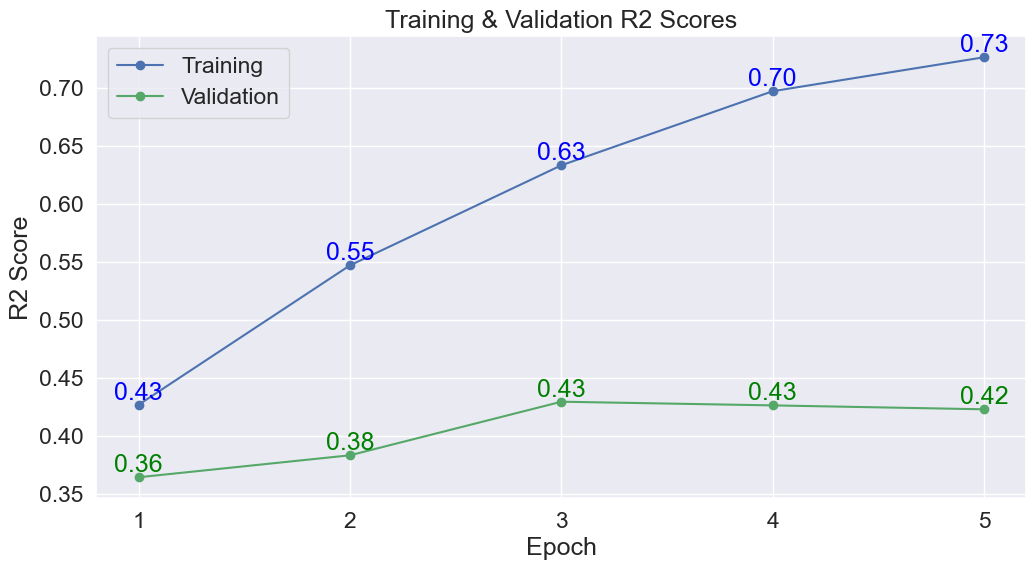

In [50]:
# plotting r^2 scores

# Plot the lines
plt.plot(df_stats['Training R2'], 'b-o', label="Training")
plt.plot(df_stats['Test R2'], 'g-o', label="Validation")

# Add the values at each marker
for i, r2_train in enumerate(df_stats['Training R2']):
    plt.text(i+1, r2_train, f"{r2_train:.2f}", ha='center', va='bottom', color='blue')
    
for i, r2_test in enumerate(df_stats['Test R2']):
    plt.text(i+1, r2_test, f"{r2_test:.2f}", ha='center', va='bottom', color='green')

# Label the plot
plt.title("Training & Validation R2 Scores")
plt.xlabel("Epoch")
plt.ylabel("R2 Score")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()